### Dataset_Prep

In [3]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import segmentation_models as sm
import tensorflow as tf
import keras
from keras.metrics import MeanIoU
import random
import glob
from sklearn.preprocessing import MinMaxScaler
import numpy as np
# from keras.applications.resnet50 import preprocess_input, decode_predictions
BACKBONE = 'resnet50'
preprocess_input = sm.get_preprocessing(BACKBONE)
# preprocess_input = keras.applications.resnet_v2.preprocess_input()

In [4]:
train_imgs = np.load('data/train_img_256.npy')
train_msks = np.load('data/train_msk_256.npy')
val_imgs = np.load('data/val_img_256.npy')
val_msks = np.load('data/val_msk_256.npy')

print(train_msks.shape)
train_imgs=np.append(train_imgs,val_imgs[127:-1,:,:,:]).reshape(-1,256, 256, 7)
train_msks=np.append(train_msks,val_msks[127:-1,:,:,:]).reshape(-1,256, 256, 4)

val_imgs=val_imgs[0:500,:,:,:]
val_msks=val_msks[0:500,:,:,:]
# print(train_imgs.shape)
# print(len(train_imgs),len(val_imgs))

(698, 256, 256, 4)


In [5]:
train_msks.shape

(797, 256, 256, 4)

In [25]:
class Augment(keras.layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        # both use the same seed, so they'll make the same random changes.
        self.augment_inputs = keras.Sequential([
                  keras.layers.RandomFlip("horizontal_and_vertical",seed=42),
                  keras.layers.RandomRotation(factor=(-0.2, 0.3) ,seed=42),
                  # keras.layers.RandomZoom(height_factor=(0.2, 0.3), seed=42),  # Zoom in/out 20%
                  # keras.layers.RandomBrightness(0.2,value_range=(0, 1), seed=42),  # Adjust contrast by 10%
                  keras.layers.RandomContrast(0.2, seed=42),
                  # keras.layers.RandomTranslation(0.05,0.05,seed=42)
                ])

        
        # Use the same seed to keep inputs and labels transformations consistent
        self.augment_labels = keras.Sequential([
                  keras.layers.RandomFlip("horizontal_and_vertical",seed=42),
                  keras.layers.RandomRotation(factor=(-0.2, 0.3),seed=42),
                  # keras.layers.RandomZoom(height_factor=(0.2, 0.3), seed=42),  # Zoom in/out 20%
                  # keras.layers.RandomTranslation(0.05,0.05,seed=42)
                ])
        self.augment_labels_1 = keras.Sequential([
                  keras.layers.RandomFlip("horizontal_and_vertical",seed=42),
                  keras.layers.RandomRotation(factor=(-0.2, 0.3),seed=42),
                  # keras.layers.RandomZoom(height_factor=(0.2, 0.3), seed=42),  # Zoom in/out 20%
                  # keras.layers.RandomTranslation(0.05,0.05,seed=42)
                ])

    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        labels_1 = self.augment_labels(labels)
        # labels_2 = self.augment_labels_1(labels[1])
        # labels = (labels_1,labels_2)
        return inputs,labels_1

In [26]:
def preprocess_data(img, mask, channel = 3, join=False):
    img = preprocess_input(img)
    print(img.shape)
    print(mask.shape)
    if(join == 'jbinary'):
        mask1= mask[:,:,0] + mask[:,:,1]
        mask_2 = tf.one_hot(tf.cast(mask1, tf.int32), depth=2)
        mask = (mask_2,mask[:,:,:3])
    if(join == 'binary'):
        mask1= mask[:,:,3:4]
        mask_2 = tf.one_hot(tf.cast(mask1, tf.int32), depth=2)
        mask = mask1
    if join == 'edge':
        mask1= mask[:,:,3:4]
        mask2 = mask[:,:,:3]
        mask = (mask1,mask2)
    
    return img, mask

def prep(data, ch, target_size=(64, 64)):
    img_dataset = tf.data.Dataset.from_tensor_slices(data)
    
    def resize_image(image):
        image = tf.image.resize(image, target_size)
        image = tf.ensure_shape(image, (target_size[0], target_size[1], ch))
        return image

    img_dataset = img_dataset.map(resize_image)
    
    for img in img_dataset.take(1):
        print(img.shape)
    
    return img_dataset
    

def trainGenerator(img_array, mask_array, batch_size, seed=None, eval_set=False,bands=6,target_size=(256, 256)):
    img_dataset = prep(img_array[:,:,:,:bands],bands,target_size)
    mask_dataset = prep(mask_array[:,:,:,:3],3,target_size)

    dataset = tf.data.Dataset.zip((img_dataset, mask_dataset))

    dataset_1 = dataset.map(lambda img, mask: preprocess_data(img, mask, 3, False), num_parallel_calls=tf.data.AUTOTUNE)

    # Continue with batching, repeating, etc.
    if eval_set!=True:
        dataset_1 = dataset_1.batch(batch_size).repeat().map(Augment()).prefetch(tf.data.AUTOTUNE)
    else:
        dataset_1 = dataset_1.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset_1

train_img_gen = trainGenerator(train_imgs,train_msks,batch_size=16,bands=6)
valid_img_gen = trainGenerator(val_imgs,val_msks,batch_size=16,eval_set=True,bands=6)

(256, 256, 6)
(256, 256, 3)
(256, 256, 6)
(256, 256, 3)


/home/gza5dr/.local/lib/python3.10/site-packages/keras/src/layers/layer.py:358: UserWarning: `build()` was called on layer 'augment_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


(256, 256, 6)
(256, 256, 3)
(256, 256, 6)
(256, 256, 3)


In [ ]:
train_img_gen

In [7]:
valid_img_gen

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 6), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))>

In [8]:
# for img in train_img_gen.take(1):
#     print(img.shape)

###### ResNet50V2

In [9]:
batch_size = 16

steps_per_epoch = len(train_imgs)//batch_size
val_steps_per_epoch = len(val_imgs)//batch_size
mIou = keras.metrics.OneHotMeanIoU(num_classes=3)
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 6
n_classes = 3

In [10]:
import tensorflow as tf


def dice_coefficient(y_true, y_pred, smooth=1e-6):
    """
    Compute the Dice coefficient between tensors of true and predicted labels.
    
    :param y_true: tensor of true labels, one-hot encoded.
    :param y_pred: tensor of predicted labels.
    :param smooth: small constant to avoid division by zero.
    :return: Dice coefficient.
    """
    # Compute the intersection
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    # Compute the union
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    # Compute the Dice coefficient
    dice = (2. * intersection + smooth) / (union + smooth)
    # Return the mean over the batch
    return tf.reduce_mean(dice)

def dice_loss(y_true, y_pred):
    """
    Compute the Dice loss, which is 1 minus the Dice coefficient.
    
    :param y_true: tensor of true labels, one-hot encoded.
    :param y_pred: tensor of predicted labels.
    :return: Dice loss.
    """
    return 1 - dice_coefficient(y_true, y_pred)
import tensorflow as tf

def mIoU(y_true, y_pred):
    """
    Calculate mean Intersection-Over-Union (mIOU) for one-hot encoded segmentation masks.
    
    :param y_true: The ground truth segmentation mask, one-hot encoded.
    :param y_pred: The predicted segmentation mask, before softmax or after argmax to one-hot encode.
    :param num_classes: The number of classes.
    :return: The mean IOU score.
    """
    # # If y_pred is not one-hot encoded (e.g., from a softmax layer), convert it using argmax
    # y_pred = tf.argmax(y_pred, axis=-1)
    # y_pred = tf.one_hot(y_pred, depth=num_classes)
    
    # Ensure the predictions are of type float32
    y_pred = tf.cast(y_pred, tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    
    # Calculate IOU for each class
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2])
    union = tf.reduce_sum(y_true, axis=[1, 2]) + tf.reduce_sum(y_pred, axis=[1, 2]) - intersection
    
    # Smooth to avoid division by zero
    iou = (intersection + 1e-7) / (union + 1e-7)
    
    # Calculate mean IOU across all classes
    mean_iou = tf.reduce_mean(iou, axis=-1)
    
    return mean_iou


def data_prep(y_true, y_pred,num_classes=2):
    # Calculate per-class TP, FP, and FN
    tp = tf.reduce_sum(y_true * y_pred, axis=[0, 1, 2])
    fp = tf.reduce_sum((1 - y_true) * y_pred, axis=[0, 1, 2])
    fn = tf.reduce_sum(y_true * (1 - y_pred), axis=[0, 1, 2])

  
    return tp, fp, fn
    
def pre_cal(y_true, y_pred,num_classes=2):
    tp, fp, fn = data_prep(y_true, y_pred,num_classes)
    precision = tp / (tp + fp + 1e-5)
    return precision
    
def rec_cal(y_true, y_pred,num_classes=2):
    tp, fp, fn = data_prep(y_true, y_pred,num_classes)
    recall = tp / (tp + fn + 1e-5)
    return recall
    
def f1_score(y_true, y_pred,num_classes=2):
    precision =  pre_cal(y_true, y_pred,num_classes)
    recall = rec_cal(y_true, y_pred,num_classes)
    f1_scores = 2 * ((precision * recall) / (precision + recall + 1e-5)) 
    return f1_scores
    
def precision_0(y_true, y_pred,num_classes=2):
    precision =  pre_cal(y_true, y_pred,num_classes)
    return precision[0]
    
def precision_1(y_true, y_pred,num_classes=2):
    precision =  pre_cal(y_true, y_pred,num_classes)
    return precision[1]
    
def precision_2(y_true, y_pred,num_classes=2):
    precision =  pre_cal(y_true, y_pred,num_classes)
    return precision[2]
    
def recall_0(y_true, y_pred,num_classes=2):
    recall = rec_cal(y_true, y_pred,num_classes)
    return recall[0]
    
def recall_1(y_true, y_pred,num_classes=2):
    recall = rec_cal(y_true, y_pred,num_classes)
    return recall[1]
    
def recall_2(y_true, y_pred,num_classes=2):
    recall = rec_cal(y_true, y_pred,num_classes)
    return recall[2]

    
def f1_score0(y_true, y_pred,num_classes=2):
    f1_scores=f1_score(y_true, y_pred,num_classes)
    return f1_scores[0]

    
def f1_score1(y_true, y_pred,num_classes=2):
    f1_scores=f1_score(y_true, y_pred,num_classes)
    return f1_scores[1]

    
def f1_score2(y_true, y_pred,num_classes=2):
    f1_scores=f1_score(y_true, y_pred,num_classes)
    return f1_scores[2]
import tensorflow as tf

def binary_crossentropy_1(y_true, y_pred, epsilon=1e-7):
    y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)  # Clip predictions to avoid log(0)
    bce = -y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)
    return tf.reduce_mean(bce)  # Return the mean Binary Crossentropy loss

def bce_dice_loss(y_true, y_pred):
    bce = binary_crossentropy_1(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    # Combining BCE and Dice loss
    return bce + dice

In [12]:

from keras.layers import Input, Conv2D
from keras.models import Model
BACKBONE = 'resnet50'
model = sm.Unet(BACKBONE, encoder_weights='imagenet', 
                input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                classes=n_classes, activation='softmax')

inp = Input(shape=(None, None, 6))
l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
out = model(l1)

model = Model(inp, out, name='irr_model')

In [13]:
model.load_weights('/scratch/gza5dr/IrrigationTypeDetection/Experinments/proposed_experiment/model_ckpt/6_res50_16_256.keras')

In [13]:
model.summary()

Model: "irr_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, None, None, 6)     │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d (Conv2D)                 │ (None, None, None, 3)     │         21 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ functional_6 (Functional)       │ (None, None, None, 3)     │ 32,561,404 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 32,561,425 (124.21 MB)

 Trainable params: 32,513,867 (124.03 MB)

 Non-trainable params: 47,558 (185.77 KB)

In [15]:
def squeeze_excitation_block(input_tensor, ratio=8):
    """
    Creates a Squeeze-and-Excitation block.

    Parameters:
    - input_tensor: Input tensor to the SE block.
    - ratio: Reduction ratio for the intermediate Dense layer.

    Returns:
    - Output tensor after applying the SE block operations.
    """
    init = input_tensor
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)
    
    se = layers.GlobalAveragePooling2D()(init)
    se = layers.Reshape(se_shape)(se)
    se = layers.Dense(filters // ratio, activation='relu', use_bias=False)(se)
    se = layers.Dense(filters, activation='sigmoid', use_bias=False)(se)
    
    x = layers.multiply([init, se])
    return x

In [23]:
from keras import layers, Model, Input

def create_edge_detection_model(base_model_output):
    # Edge detection model layers
    edge_output = layers.Conv2D(256, (3, 3), padding='same')(base_model_output)
    edge_output = layers.BatchNormalization()(edge_output)
    edge_output = layers.Activation('relu')(edge_output)

    edge_output = layers.Conv2D(128, (3, 3), padding='same')(edge_output)
    edge_output = layers.BatchNormalization()(edge_output)
    edge_output = layers.Activation('relu')(edge_output)

    edge_output = layers.Conv2D(2, (3, 3), padding='same')(edge_output)
    edge_output = layers.BatchNormalization()(edge_output)
    edge_output = layers.Activation('softmax',name='edge')(edge_output)
    
    return edge_output

def hybrid_model(base_model, input_shape=(256, 256, 6)):
    # Assuming 'base_model' is defined and compiled outside this function

    # Redefine the input to accommodate 6 channels
    inputs = Input(shape=input_shape, name='input_layer')

    # Assuming the base_model is meant to process the input and then feed into the edge detection
    # Use the redefined input for the base_model
    # Ensure the base_model is adaptable to the new input shape if it was pre-trained with a different input shape
    x = base_model(inputs)
    
    base_model_output = x  # Directly use the output of the base model assuming it's already the desired layer output

    # Create edge detection output
    edge_model_output = create_edge_detection_model(base_model_output)

    # Example of concatenating features from the base model and edge model outputs
    combined_features = layers.concatenate([base_model_output, edge_model_output], axis=-1)
    
    enhanced_features = squeeze_excitation_block(combined_features, ratio=16)


    # Additional layers after merging
    x = layers.Conv2D(256, (3, 3), padding='same')(base_model_output)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    final_output = layers.Conv2D(3, (1, 1), activation='softmax', name='irr')(x)  # Example for multiclass segmentation

    # Construct the model
    model = Model(inputs=inputs, outputs=[edge_model_output, final_output], name='hybrid_model')

    return model


In [24]:
hm = hybrid_model(model)
# hm.summary()

In [25]:
# model.layers[-3]

In [26]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.00000001)
checkpoint_filepath = 'model_ckpt/6_res50_16_256_boundary.keras'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [27]:
hm.compile(optimizer=keras.optimizers.Adam(learning_rate=.00004), loss={
                                              'irr':bce_dice_loss,'edge':bce_dice_loss}, 
                                              loss_weights={'irr':2.,'edge':.89},
                                              metrics={
                                             'irr':['accuracy','precision','recall',mIoU,
                                              f1_score,f1_score0,f1_score1,f1_score2,
                                              precision_0,precision_1,precision_2,recall_0,recall_1,recall_2],
                                              'edge':['accuracy','precision','recall',mIoU] })

In [28]:
history=hm.fit(train_img_gen,
          steps_per_epoch=steps_per_epoch,
          epochs=30,
          verbose=1,
          validation_data=valid_img_gen,
          validation_steps=val_steps_per_epoch,
        callbacks=[reduce_lr,model_checkpoint_callback])

Epoch 1/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 62s 357ms/step - edge_accuracy: 0.7636 - edge_m_io_u: 0.5174 - edge_precision: 0.7892 - edge_recall: 0.7478 - irr_accuracy: 0.6744 - irr_f1_score: 0.5742 - irr_f1_score0: 0.5742 - irr_f1_score1: 0.5341 - irr_f1_score2: 0.6143 - irr_m_io_u: 0.3622 - irr_precision: 0.7839 - irr_precision_0: 0.5253 - irr_precision_1: 0.5090 - irr_precision_2: 0.7153 - irr_recall: 0.5558 - irr_recall_0: 0.6560 - irr_recall_1: 0.5697 - irr_recall_2: 0.5540 - loss: 2.4367 - val_edge_accuracy: 0.8381 - val_edge_m_io_u: 0.3580 - val_edge_precision: 0.8381 - val_edge_recall: 0.8381 - val_irr_accuracy: 0.7947 - val_irr_f1_score: 0.3841 - val_irr_f1_score0: 0.3525 - val_irr_f1_score1: 0.3051 - val_irr_f1_score2: 0.4947 - val_irr_m_io_u: 0.2218 - val_irr_precision: 0.0000e+00 - val_irr_precision_0: 0.3516 - val_irr_precision_1: 0.2583 - val_irr_precision_2: 0.5595 - val_irr_recall: 0.0000e+00 - val_irr_recall_0: 0.3584 - val_irr_recall_1: 0.3809 - val_irr_recall_2: 0.4441 - va

In [ ]:
history=hm.fit(train_img_gen,
          steps_per_epoch=steps_per_epoch,
          epochs=50,
          verbose=1,
          validation_data=valid_img_gen,
          validation_steps=val_steps_per_epoch,
        callbacks=[reduce_lr,model_checkpoint_callback])

Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 12s 238ms/step - edge_accuracy: 0.9068 - edge_m_io_u: 0.6685 - edge_precision: 0.9310 - edge_recall: 0.8821 - irr_accuracy: 0.8683 - irr_f1_score: 0.8184 - irr_f1_score0: 0.7866 - irr_f1_score1: 0.7977 - irr_f1_score2: 0.8711 - irr_m_io_u: 0.5757 - irr_precision: 0.9021 - irr_precision_0: 0.7879 - irr_precision_1: 0.7925 - irr_precision_2: 0.8718 - irr_recall: 0.8321 - irr_recall_0: 0.7859 - irr_recall_1: 0.8038 - irr_recall_2: 0.8708 - loss: 1.2061 - val_edge_accuracy: 0.8695 - val_edge_m_io_u: 0.6350 - val_edge_precision: 0.8695 - val_edge_recall: 0.8695 - val_irr_accuracy: 0.8119 - val_irr_f1_score: 0.7501 - val_irr_f1_score0: 0.6999 - val_irr_f1_score1: 0.7061 - val_irr_f1_score2: 0.8443 - val_irr_m_io_u: 0.5170 - val_irr_precision: 0.8214 - val_irr_precision_0: 0.7358 - val_irr_precision_1: 0.7031 - val_irr_precision_2: 0.8251 - val_irr_recall: 0.8019 - val_irr_recall_0: 0.6683 - val_irr_recall_1: 0.7100 - val_irr_recall_2: 0.8648 - val_loss: 

In [16]:
model.load_weights('model_ckpt/6_res50_16_128.keras')

model.evaluate(valid_img_gen)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7526 - f1_score: 0.7348 - f1_score0: 0.6873 - f1_score1: 0.6926 - f1_score2: 0.8245 - loss: 0.2477 - m_io_u: 0.4517 - precision: 0.7527 - precision_0: 0.7169 - precision_1: 0.6838 - precision_2: 0.8068 - recall: 0.7525 - recall_0: 0.6604 - recall_1: 0.7022 - recall_2: 0.8439


[0.25396662950515747,
 0.7461684346199036,
 0.7285561561584473,
 0.6952319741249084,
 0.6732478141784668,
 0.8171885013580322,
 0.4460592567920685,
 0.7463210821151733,
 0.7289214134216309,
 0.6721785068511963,
 0.7904694676399231,
 0.7460450530052185,
 0.6646996140480042,
 0.6752638220787048,
 0.8465959429740906]

In [23]:
history=model.fit(train_img_gen,
          steps_per_epoch=steps_per_epoch,
          epochs=10,
          verbose=2,
          validation_data=valid_img_gen,
          validation_steps=val_steps_per_epoch,callbacks=[reduce_lr,model_checkpoint_callback])

Epoch 1/10
555/555 - 115s - 207ms/step - accuracy: 0.7969 - loss: 0.2044 - m_io_u: 0.4188 - precision: 0.8293 - recall: 0.7686 - val_accuracy: 0.6615 - val_loss: 0.3392 - val_m_io_u: 0.3567 - val_precision: 0.6617 - val_recall: 0.6612 - learning_rate: 1.6000e-06
Epoch 2/10
555/555 - 55s - 99ms/step - accuracy: 0.7982 - loss: 0.2031 - m_io_u: 0.4194 - precision: 0.8305 - recall: 0.7698 - val_accuracy: 0.6617 - val_loss: 0.3390 - val_m_io_u: 0.3567 - val_precision: 0.6619 - val_recall: 0.6615 - learning_rate: 1.6000e-06
Epoch 3/10
555/555 - 53s - 96ms/step - accuracy: 0.7988 - loss: 0.2025 - m_io_u: 0.4200 - precision: 0.8311 - recall: 0.7704 - val_accuracy: 0.6627 - val_loss: 0.3380 - val_m_io_u: 0.3571 - val_precision: 0.6629 - val_recall: 0.6624 - learning_rate: 1.6000e-06
Epoch 4/10


2024-03-21 05:20:57.150117: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 7853775885380661918
2024-03-21 05:20:57.150170: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 9520178516596869840


555/555 - 53s - 95ms/step - accuracy: 0.7991 - loss: 0.2022 - m_io_u: 0.4201 - precision: 0.8314 - recall: 0.7706 - val_accuracy: 0.6636 - val_loss: 0.3371 - val_m_io_u: 0.3575 - val_precision: 0.6638 - val_recall: 0.6633 - learning_rate: 1.6000e-06
Epoch 5/10
555/555 - 52s - 94ms/step - accuracy: 0.7996 - loss: 0.2017 - m_io_u: 0.4205 - precision: 0.8320 - recall: 0.7711 - val_accuracy: 0.6631 - val_loss: 0.3376 - val_m_io_u: 0.3581 - val_precision: 0.6633 - val_recall: 0.6628 - learning_rate: 1.6000e-06
Epoch 6/10


2024-03-21 05:21:50.250795: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 7853775885380661918
2024-03-21 05:21:50.250857: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 9520178516596869840


555/555 - 53s - 95ms/step - accuracy: 0.7999 - loss: 0.2014 - m_io_u: 0.4210 - precision: 0.8323 - recall: 0.7714 - val_accuracy: 0.6627 - val_loss: 0.3381 - val_m_io_u: 0.3573 - val_precision: 0.6629 - val_recall: 0.6624 - learning_rate: 1.6000e-06
Epoch 7/10
555/555 - 54s - 97ms/step - accuracy: 0.8005 - loss: 0.2008 - m_io_u: 0.4217 - precision: 0.8329 - recall: 0.7719 - val_accuracy: 0.6636 - val_loss: 0.3372 - val_m_io_u: 0.3583 - val_precision: 0.6638 - val_recall: 0.6633 - learning_rate: 1.6000e-06
Epoch 8/10
555/555 - 52s - 94ms/step - accuracy: 0.8008 - loss: 0.2005 - m_io_u: 0.4223 - precision: 0.8332 - recall: 0.7723 - val_accuracy: 0.6629 - val_loss: 0.3377 - val_m_io_u: 0.3580 - val_precision: 0.6632 - val_recall: 0.6627 - learning_rate: 3.2000e-07
Epoch 9/10
555/555 - 53s - 95ms/step - accuracy: 0.8010 - loss: 0.2003 - m_io_u: 0.4220 - precision: 0.8334 - recall: 0.7724 - val_accuracy: 0.6632 - val_loss: 0.3375 - val_m_io_u: 0.3583 - val_precision: 0.6634 - val_recall: 0.

2024-03-21 05:26:14.839025: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 7853775885380661918
2024-03-21 05:26:14.839113: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 9520178516596869840


In [49]:
model.evaluate(valid_img_gen)

ValueError: Creating variables on a non-first call to a function decorated with tf.function.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(16, 256, 256, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
(16, 256, 256, 3)


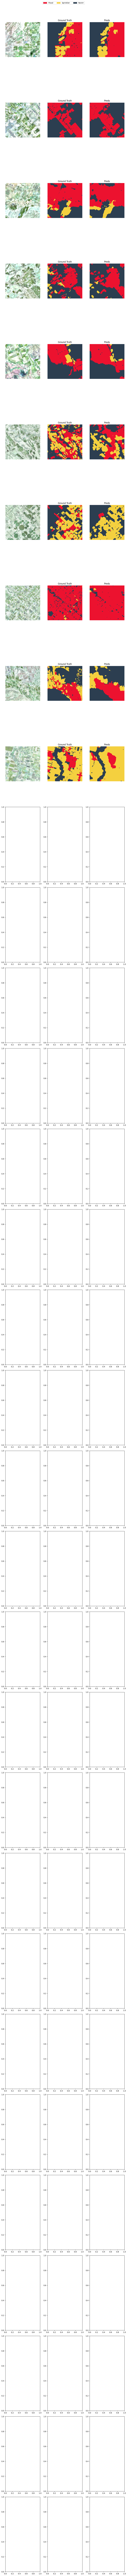

In [32]:
# import matplotlib.pyplot as plt
# import numpy as np
# import tensorflow as tf
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch
# Assuming model, valid_img_gen are defined, and weights are loaded
x = train_img_gen.take(2)
fig, axs = plt.subplots(32, 3, figsize=(10, 200))

# Define colors for each class, adjust as needed
class_colors = ['#EC122F', '#F4D03F', '#2C3E50','#145A32']  # Example for 3 classes
custom_cmap = ListedColormap(class_colors)
# Assuming your class labels are 0, 1, 2, etc., adjust boundaries accordingly
# Boundaries should cover all your class labels
class_labels = [0, 1, 2,3]  # Example for 3 classes, adjust as needed
# We add one more boundary than classes to ensure proper mapping
boundaries = np.arange(min(class_labels) - 0.5, max(class_labels) + 1.5, 1)
norm = BoundaryNorm(boundaries, custom_cmap.N, clip=True)
class_names = ['Flood','Sprinkler','NonIrr']

cnt = 0
legend_handles = [Patch(color=color, label=label) for color, label in zip(class_colors, class_names)]
i=0
for images, labels in x:
    if cnt == 2:
        break
    preds = model.predict(images)
    print(np.array(labels).shape)
    for j in range(5):

        image = images[j].numpy()
        label = labels[j].numpy()  # Adjusted for direct numpy conversion
        masks = np.argmax(label, axis=-1)
        pred_mask = np.argmax(preds[j], axis=-1)


        # Display the image
        axs[i][0].imshow(image[:, :, :3])
        # Display the true mask with custom colors
        axs[i][1].imshow(masks, cmap=custom_cmap, norm=norm, interpolation='nearest')
        # Display the predicted mask with custom colors
        axs[i][2].imshow(pred_mask, cmap=custom_cmap, norm=norm, interpolation='nearest')

        
        axs[i][1].set_title('Ground Truth')
        axs[i][2].set_title('Preds')
   
        # Remove ticks
        axs[i][0].axis('off')
        axs[i][1].axis('off')
        axs[i][2].axis('off')

        i=i+1

    cnt = cnt+1

# Add the legend at the top of the figure
fig.legend(handles=legend_handles, loc='lower center', bbox_to_anchor=(0.5, .998), ncol=len(class_names))

# Adjust layout to make space for the legend
plt.tight_layout(rect=[0, 0, 1, 1])  # Adjust the bottom, top, left, right values as needed

plt.show()


In [51]:
model.evaluate(valid_img_gen)

15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 317ms/step - accuracy: 0.8127 - f1_score: 0.7892 - f1_score0: 0.7509 - f1_score1: 0.7466 - f1_score2: 0.8702 - loss: 0.1875 - m_io_u: 0.5454 - precision: 0.8128 - precision_0: 0.7502 - precision_1: 0.7536 - precision_2: 0.8703 - recall: 0.8126 - recall_0: 0.7529 - recall_1: 0.7411 - recall_2: 0.8708


[0.17191141843795776,
 0.8277317881584167,
 0.8064591288566589,
 0.7747735977172852,
 0.76536625623703,
 0.8792374134063721,
 0.5809454321861267,
 0.8278047442436218,
 0.7858483195304871,
 0.778040885925293,
 0.8702126145362854,
 0.8276768326759338,
 0.765670895576477,
 0.7541950345039368,
 0.8889550566673279]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


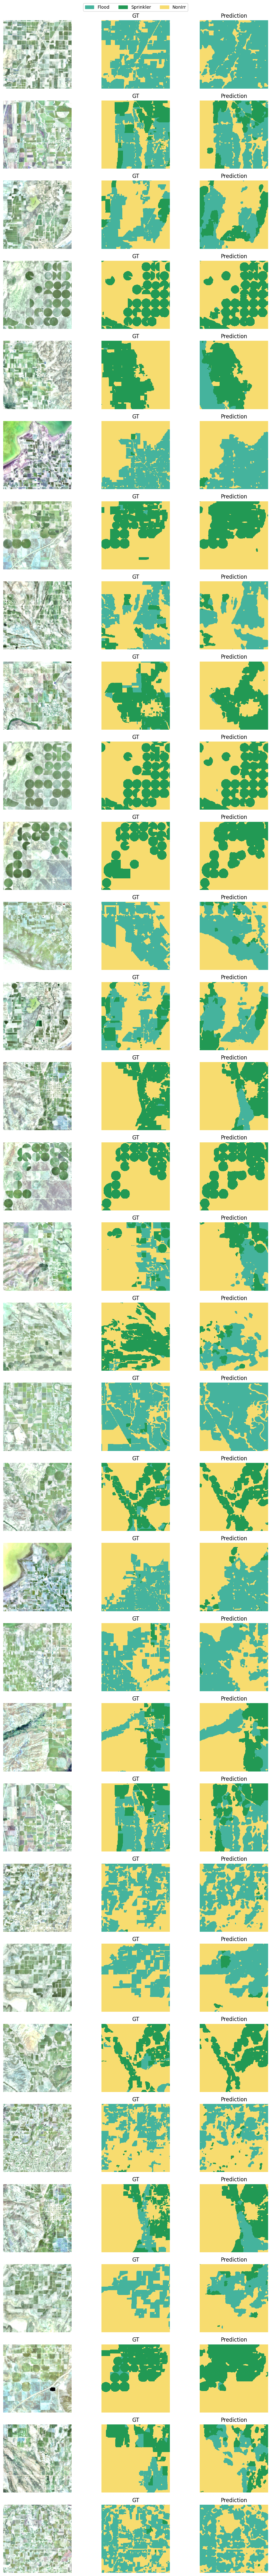

In [19]:
# import matplotlib.pyplot as plt
# import numpy as np
# import tensorflow as tf
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch
# Assuming model, valid_img_gen are defined, and weights are loaded
x = valid_img_gen.take(5)
fig, axs = plt.subplots(32, 3, figsize=(10, 80))

# Define colors for each class, adjust as needed
class_colors = ['#45B39D', '#229954', '#F7DC6F','#145A32']  # Example for 3 classes
custom_cmap = ListedColormap(class_colors)
# Assuming your class labels are 0, 1, 2, etc., adjust boundaries accordingly
# Boundaries should cover all your class labels
class_labels = [0, 1, 2,3]  # Example for 3 classes, adjust as needed
# We add one more boundary than classes to ensure proper mapping
boundaries = np.arange(min(class_labels) - 0.5, max(class_labels) + 1.5, 1)
norm = BoundaryNorm(boundaries, custom_cmap.N, clip=True)
class_names = ['Flood','Sprinkler','NonIrr']

cnt = 0
legend_handles = [Patch(color=color, label=label) for color, label in zip(class_colors, class_names)]
i=0
for images, labels in x:
    if cnt == 2:
        break
    preds = model.predict(images)
    for j in range(16):
        
        image = images[j].numpy()
        label = labels[j].numpy()  # Adjusted for direct numpy conversion
        masks = np.argmax(label, axis=-1)
        pred_mask = np.argmax(preds[j], axis=-1)

        # Display the image
        axs[i][0].imshow(image[:, :, :3])
        # Display the true mask with custom colors
        axs[i][1].imshow(masks, cmap=custom_cmap, norm=norm, interpolation='nearest')
        # Display the predicted mask with custom colors
        axs[i][2].imshow(pred_mask, cmap=custom_cmap, norm=norm, interpolation='nearest')
        
        axs[i][1].set_title('GT')
        axs[i][2].set_title('Prediction')

        # Remove ticks
        axs[i][0].axis('off')
        axs[i][1].axis('off')
        axs[i][2].axis('off')
        
        i=i+1

    cnt = cnt+1

# Add the legend at the top of the figure
fig.legend(handles=legend_handles, loc='lower center', bbox_to_anchor=(0.5, .998), ncol=len(class_names))

# Adjust layout to make space for the legend
plt.tight_layout(rect=[0, 0, 1, 1])  # Adjust the bottom, top, left, right values as needed

plt.show()


In [50]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=.00004), loss=dice_loss, 
                                              metrics=['accuracy','precision','recall',mIoU,
                                              f1_score,f1_score0,f1_score1,f1_score2,
                                              precision_0,precision_1,precision_2,recall_0,recall_1,recall_2])

In [19]:
model.load_weights('model_ckpt/mres50_1.weights.h5')
x = valid_img_gen.take(1)
fig,axs = plt.subplots(16,3,figsize=(10, 50))
for images,labels in x:
    # print(images.shape)
    preds=model.predict(images)
    # print(np.array(preds).shape)
    for i in range(16):
        image = images[i].numpy()
        # image = cv2.normalize(image, None, alpha = 0, beta = 1, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
        print(labels[i].shape)
        masks = np.argmax(labels[i],axis=-1)
        pred_mask = np.argmax(preds[i],axis=-1)
        axs[i][0].imshow(image)
        axs[i][1].imshow(masks)
        axs[i][2].imshow(pred_mask)
    break

ValueError: Layer 'conv2d' expected 2 variables, but received 1 variables during loading. Expected: ['kernel', 'bias']

### Extra

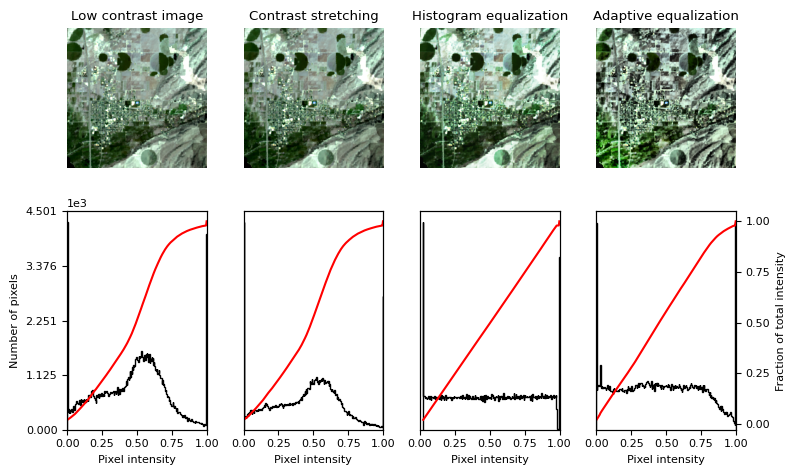

In [27]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np




matplotlib.rcParams['font.size'] = 8


def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf


im = iter(training.take(2)).next()
img = im[0].numpy()[0][:,:,0:3]+np.array([0.5,0.6,0.5])
img = normalize_satellite_image(img)
# # Load an example image
# img = data.moon()

# Contrast stretching
p2, p98 = np.percentile(img, (3, 98))
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

# Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)

# Display results
fig = plt.figure(figsize=(8, 5))
axes = np.zeros((2, 4), dtype=object)
axes[0, 0] = fig.add_subplot(2, 4, 1)
for i in range(1, 4):
    axes[0, i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0,0], sharey=axes[0,0])
for i in range(0, 4):
    axes[1, i] = fig.add_subplot(2, 4, 5+i)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Contrast stretching')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Histogram equalization')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])
ax_img.set_title('Adaptive equalization')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()